# GeoBench MMFlood

In [1]:
import os
from pathlib import Path

import torch

from geobench_v2.datamodules import GeoBenchMMFloodDataModule
from geobench_v2.datasets import GeoBenchMMFlood
from geobench_v2.datasets.normalization import SatMAENormalizer, ZScoreNormalizer
from geobench_v2.datasets.visualization_util import (
    compare_normalization_methods,
    compute_batch_histograms,
    plot_batch_histograms,
    plot_channel_histograms,
    visualize_segmentation_target_statistics,
)

%load_ext autoreload
%autoreload 2

In [2]:
PROJECT_ROOT = Path("../../")

STATS_SATMAE_PATH = os.path.join(
    PROJECT_ROOT, "geobench_v2", "datamodules", "dataset_stats_satmae", "mmflood", "mmflood_stats.json"
)
STATS_CLIP_RESCALE_PATH = os.path.join(
    PROJECT_ROOT, "geobench_v2", "datamodules", "dataset_stats_clip_rescale", "mmflood", "mmflood_stats.json"
)


In [3]:
band_order = GeoBenchMMFlood.band_default_order

datamodule = GeoBenchMMFloodDataModule(
    img_size=256,
    batch_size=16,
    num_workers=4,
    root=PROJECT_ROOT / "data" / "mmflood",
    band_order=band_order,
    data_normalizer=torch.nn.Identity(),  # we do custom normalization in the tutorial
)
datamodule.setup("fit")

Using provided pre-initialized normalizer instance: Identity
Using provided pre-initialized normalizer instance: Identity


Map extent: Longitude [-101.53° to 157.99°], Latitude [-38.81° to 75.55°]
Found 3 dataset splits: test, train, validation


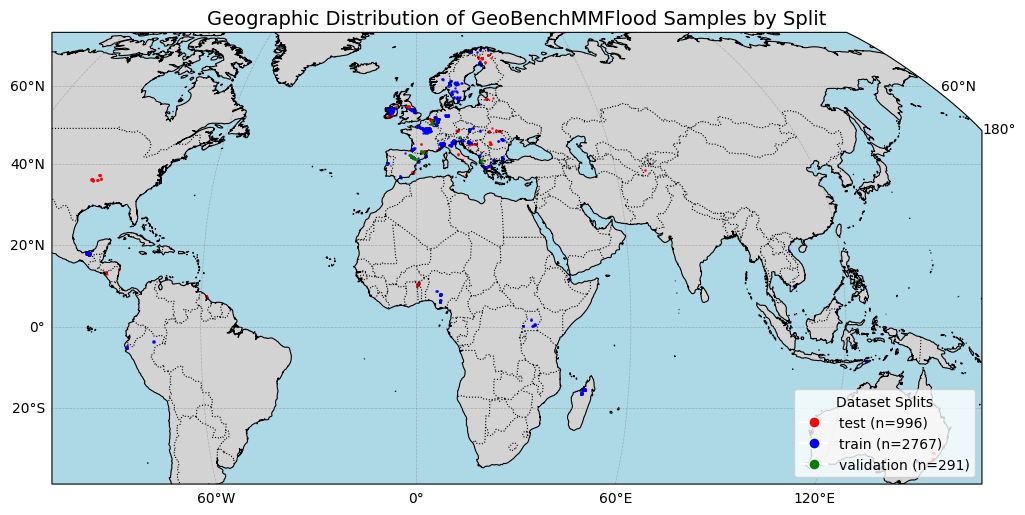

In [4]:
sample_dist_fig = datamodule.visualize_geospatial_distribution()

## Dataset Statistics

Computed over the training dataset.

### Image Statistics

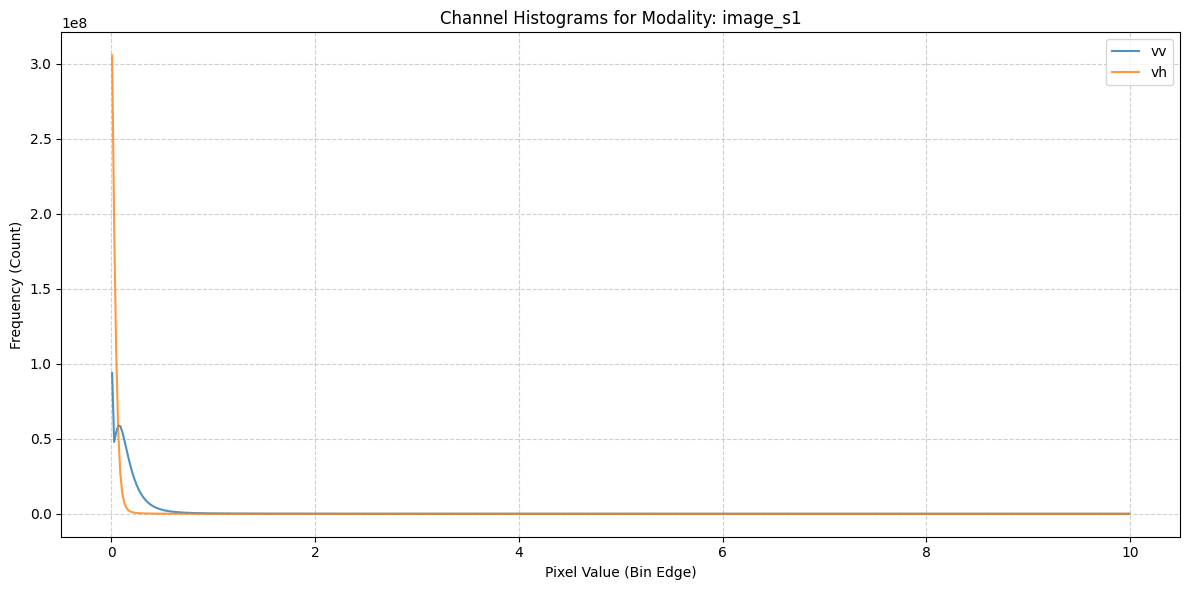

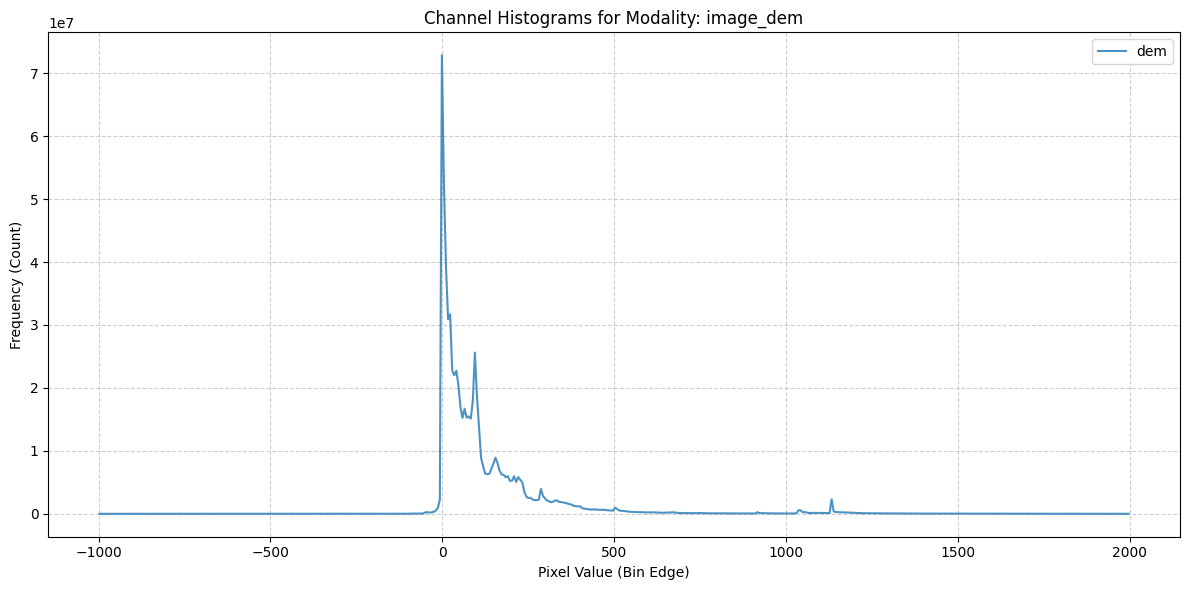

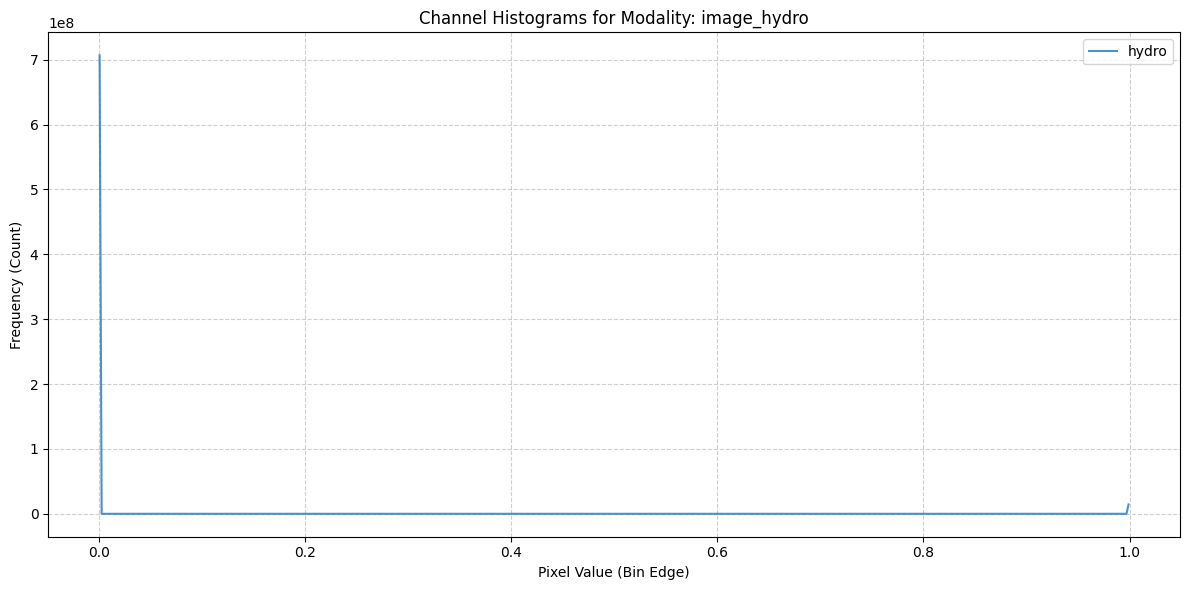

In [5]:
fig = plot_channel_histograms(STATS_SATMAE_PATH)


### Target Statistics

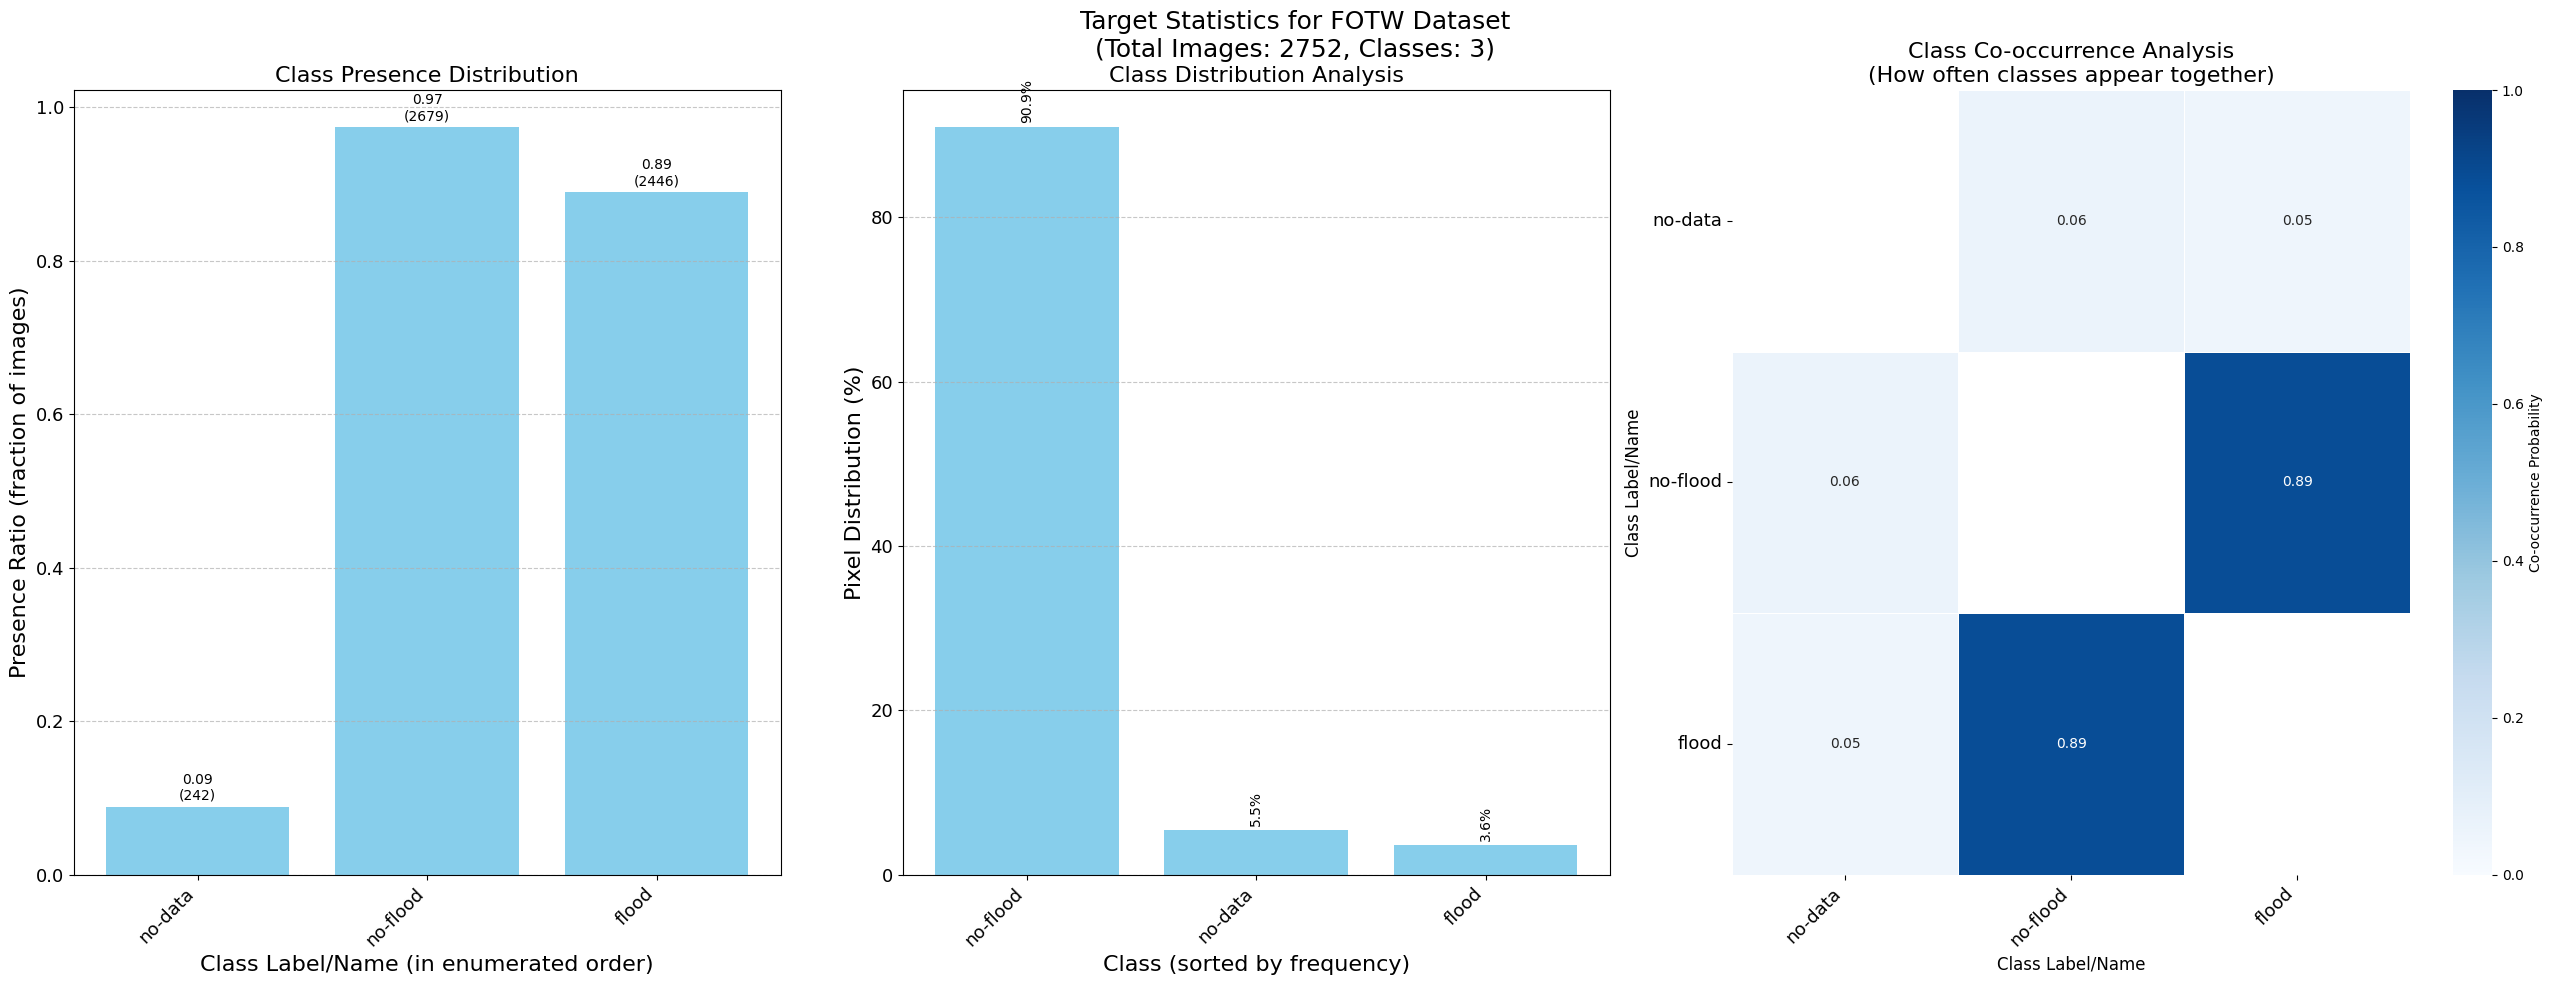

In [6]:
figs = visualize_segmentation_target_statistics(
    STATS_SATMAE_PATH,
    "FOTW",
)

### Raw Batch Image Statistics

Statistics of a single batch before any normalization

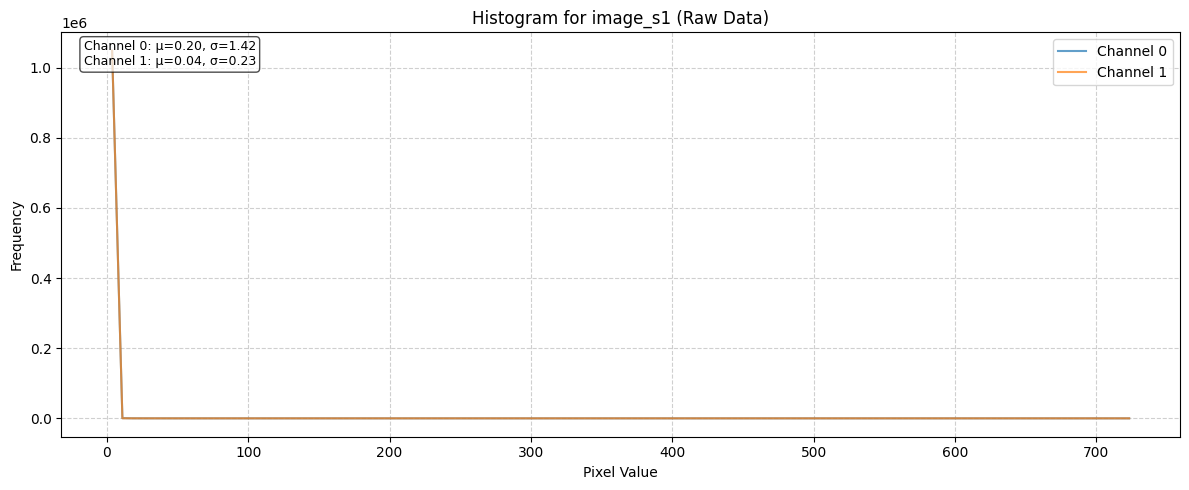

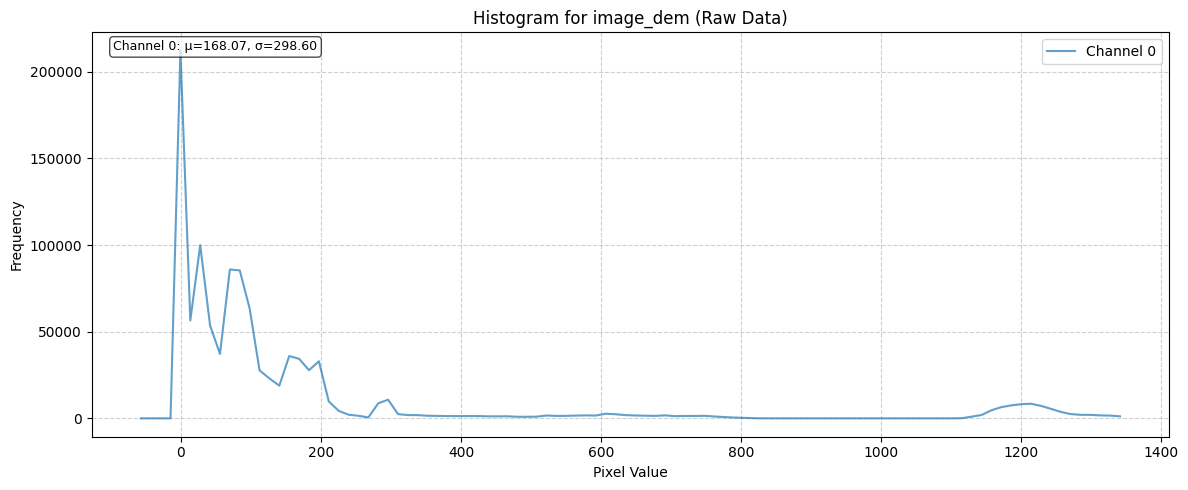

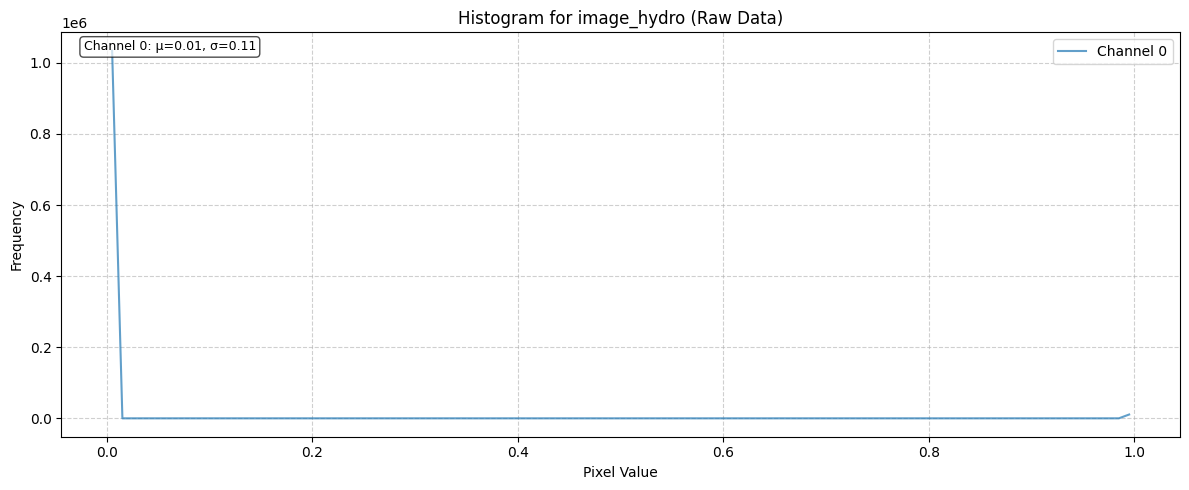

In [7]:
# Get a batch of data from the dataloader
train_dataloader = datamodule.train_dataloader()
raw_batch = next(iter(train_dataloader))

raw_batch_stats = compute_batch_histograms(raw_batch, n_bins=100)

raw_figs = plot_batch_histograms(
    raw_batch_stats, band_order, title_suffix=" (Raw Data)"
)

## Effect of different Normalization Schemes

In [8]:
zscore_normalizer = ZScoreNormalizer(STATS_CLIP_RESCALE_PATH, band_order)
satmae_normalizer = SatMAENormalizer(STATS_SATMAE_PATH, band_order)

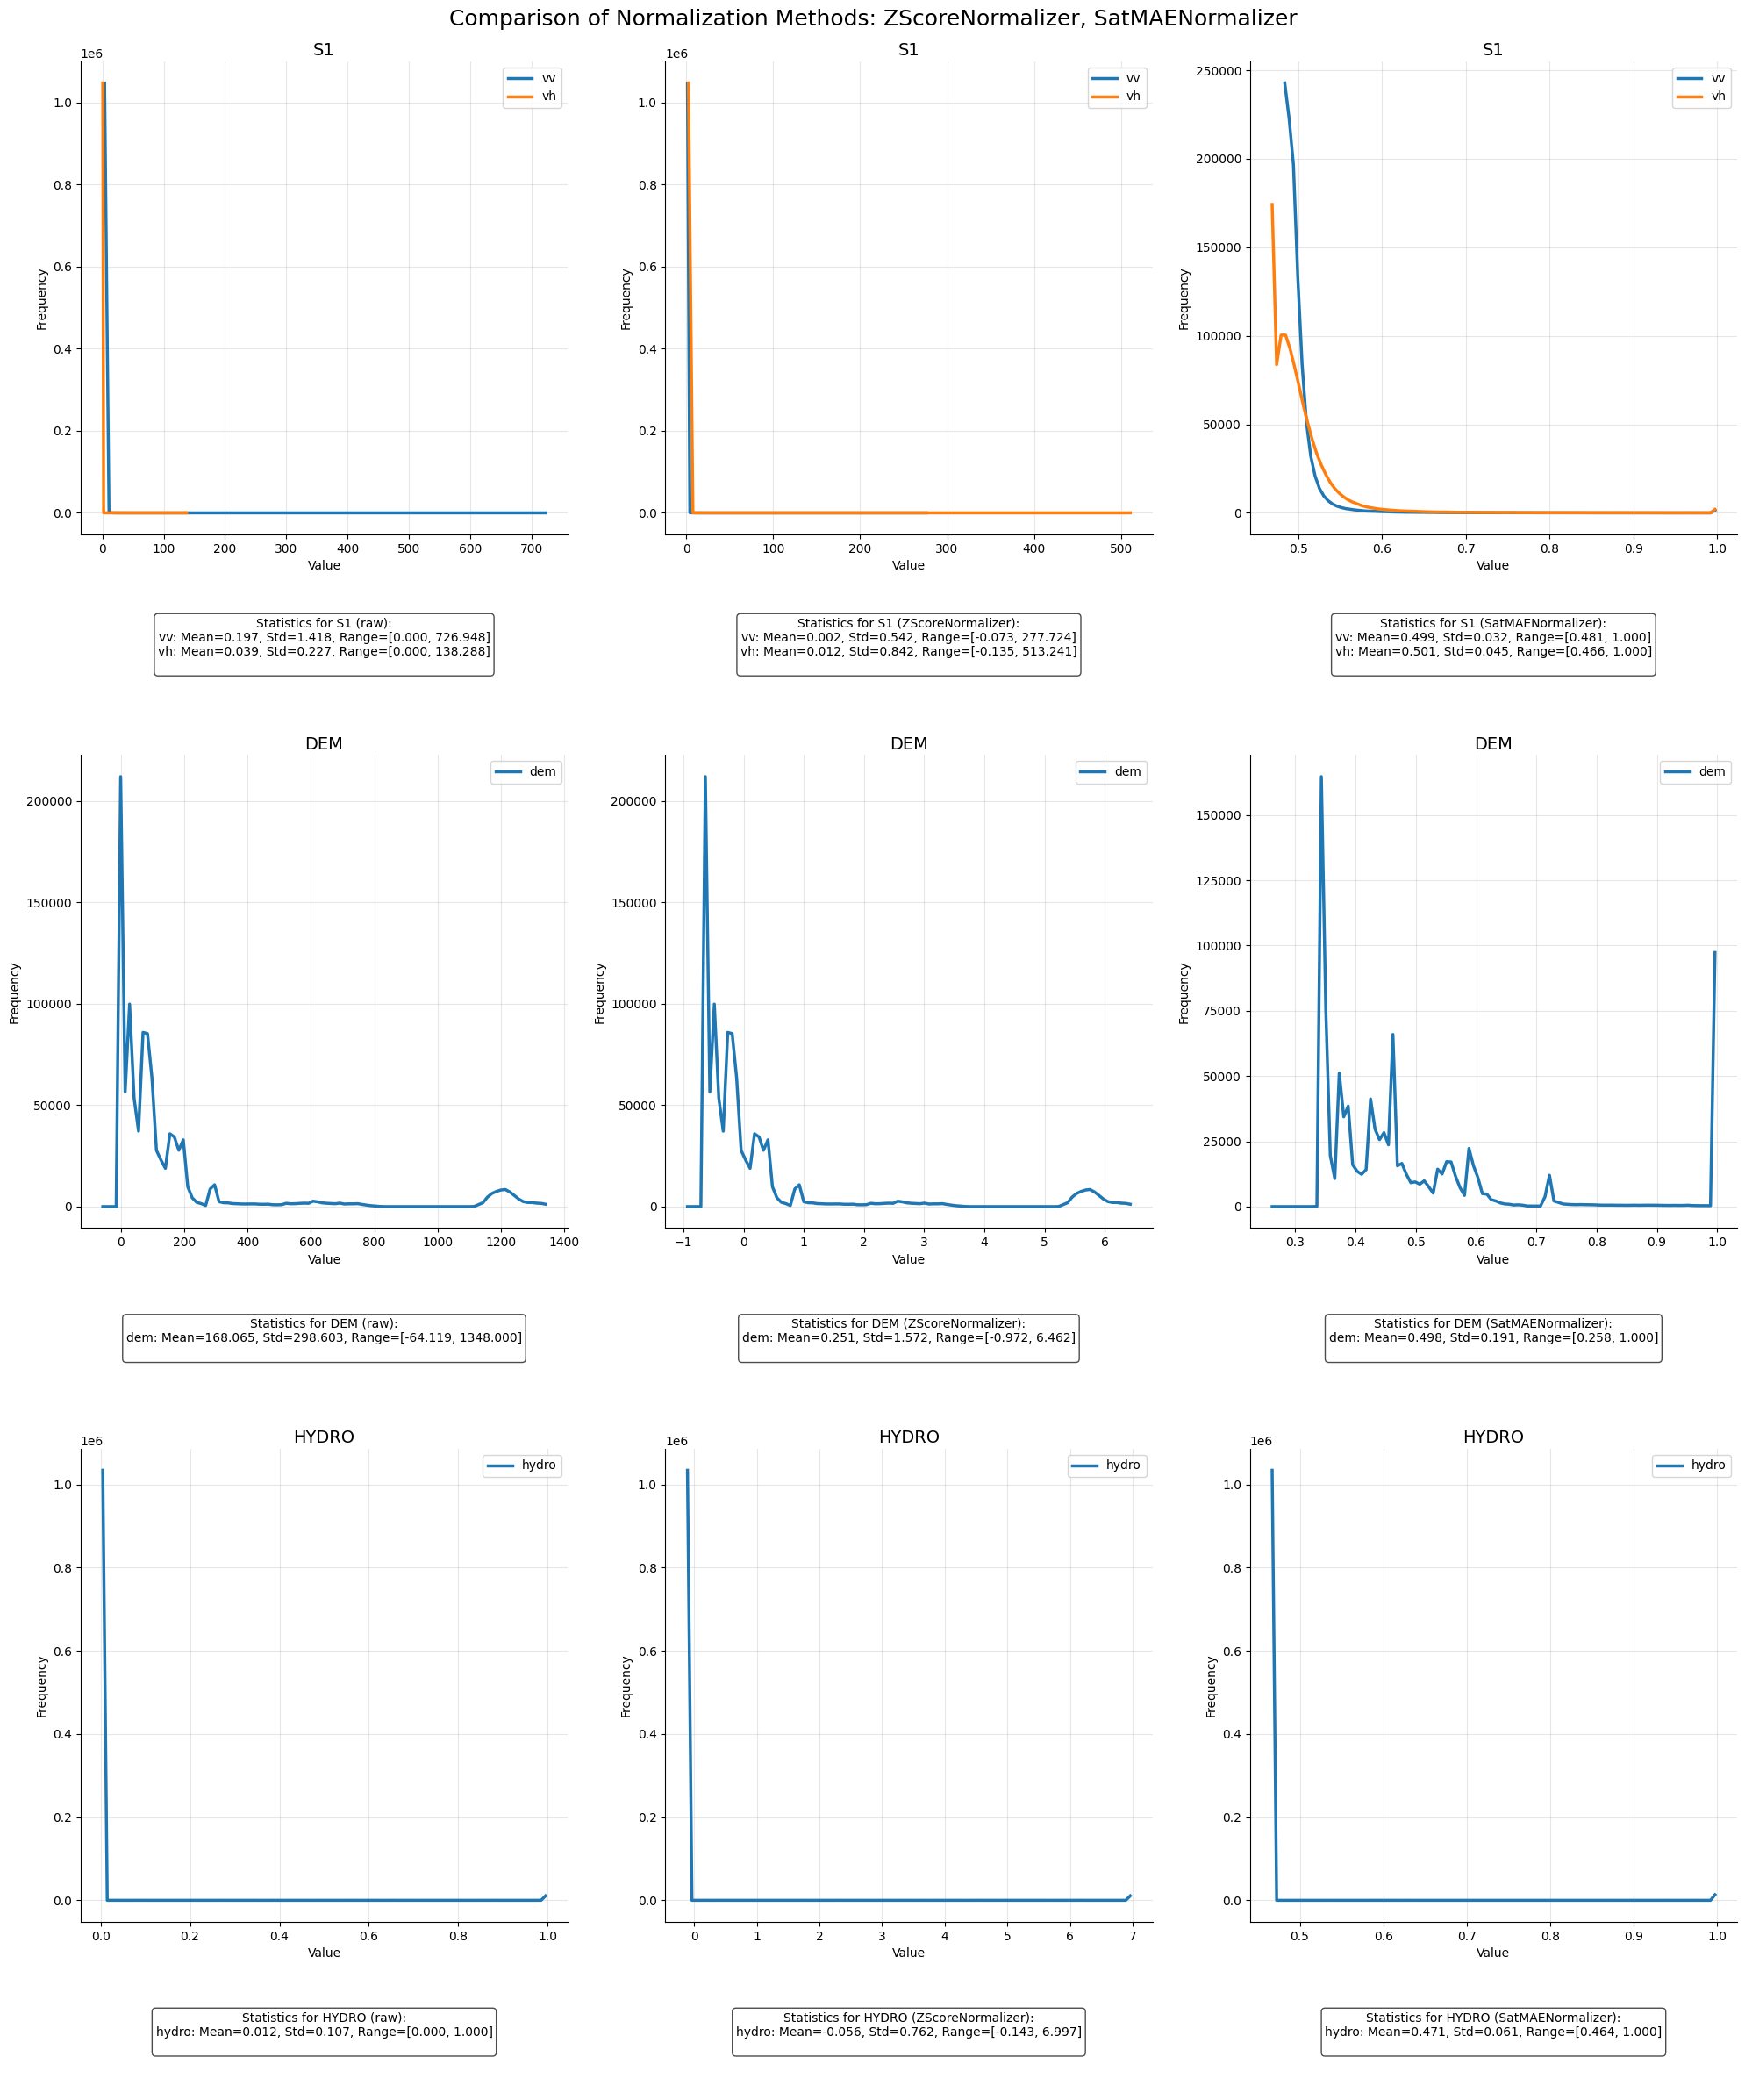

In [9]:
norm_fig, normalized_batches = compare_normalization_methods(
    raw_batch,
    [zscore_normalizer, satmae_normalizer],
    datamodule,
)

## Visualize Batch

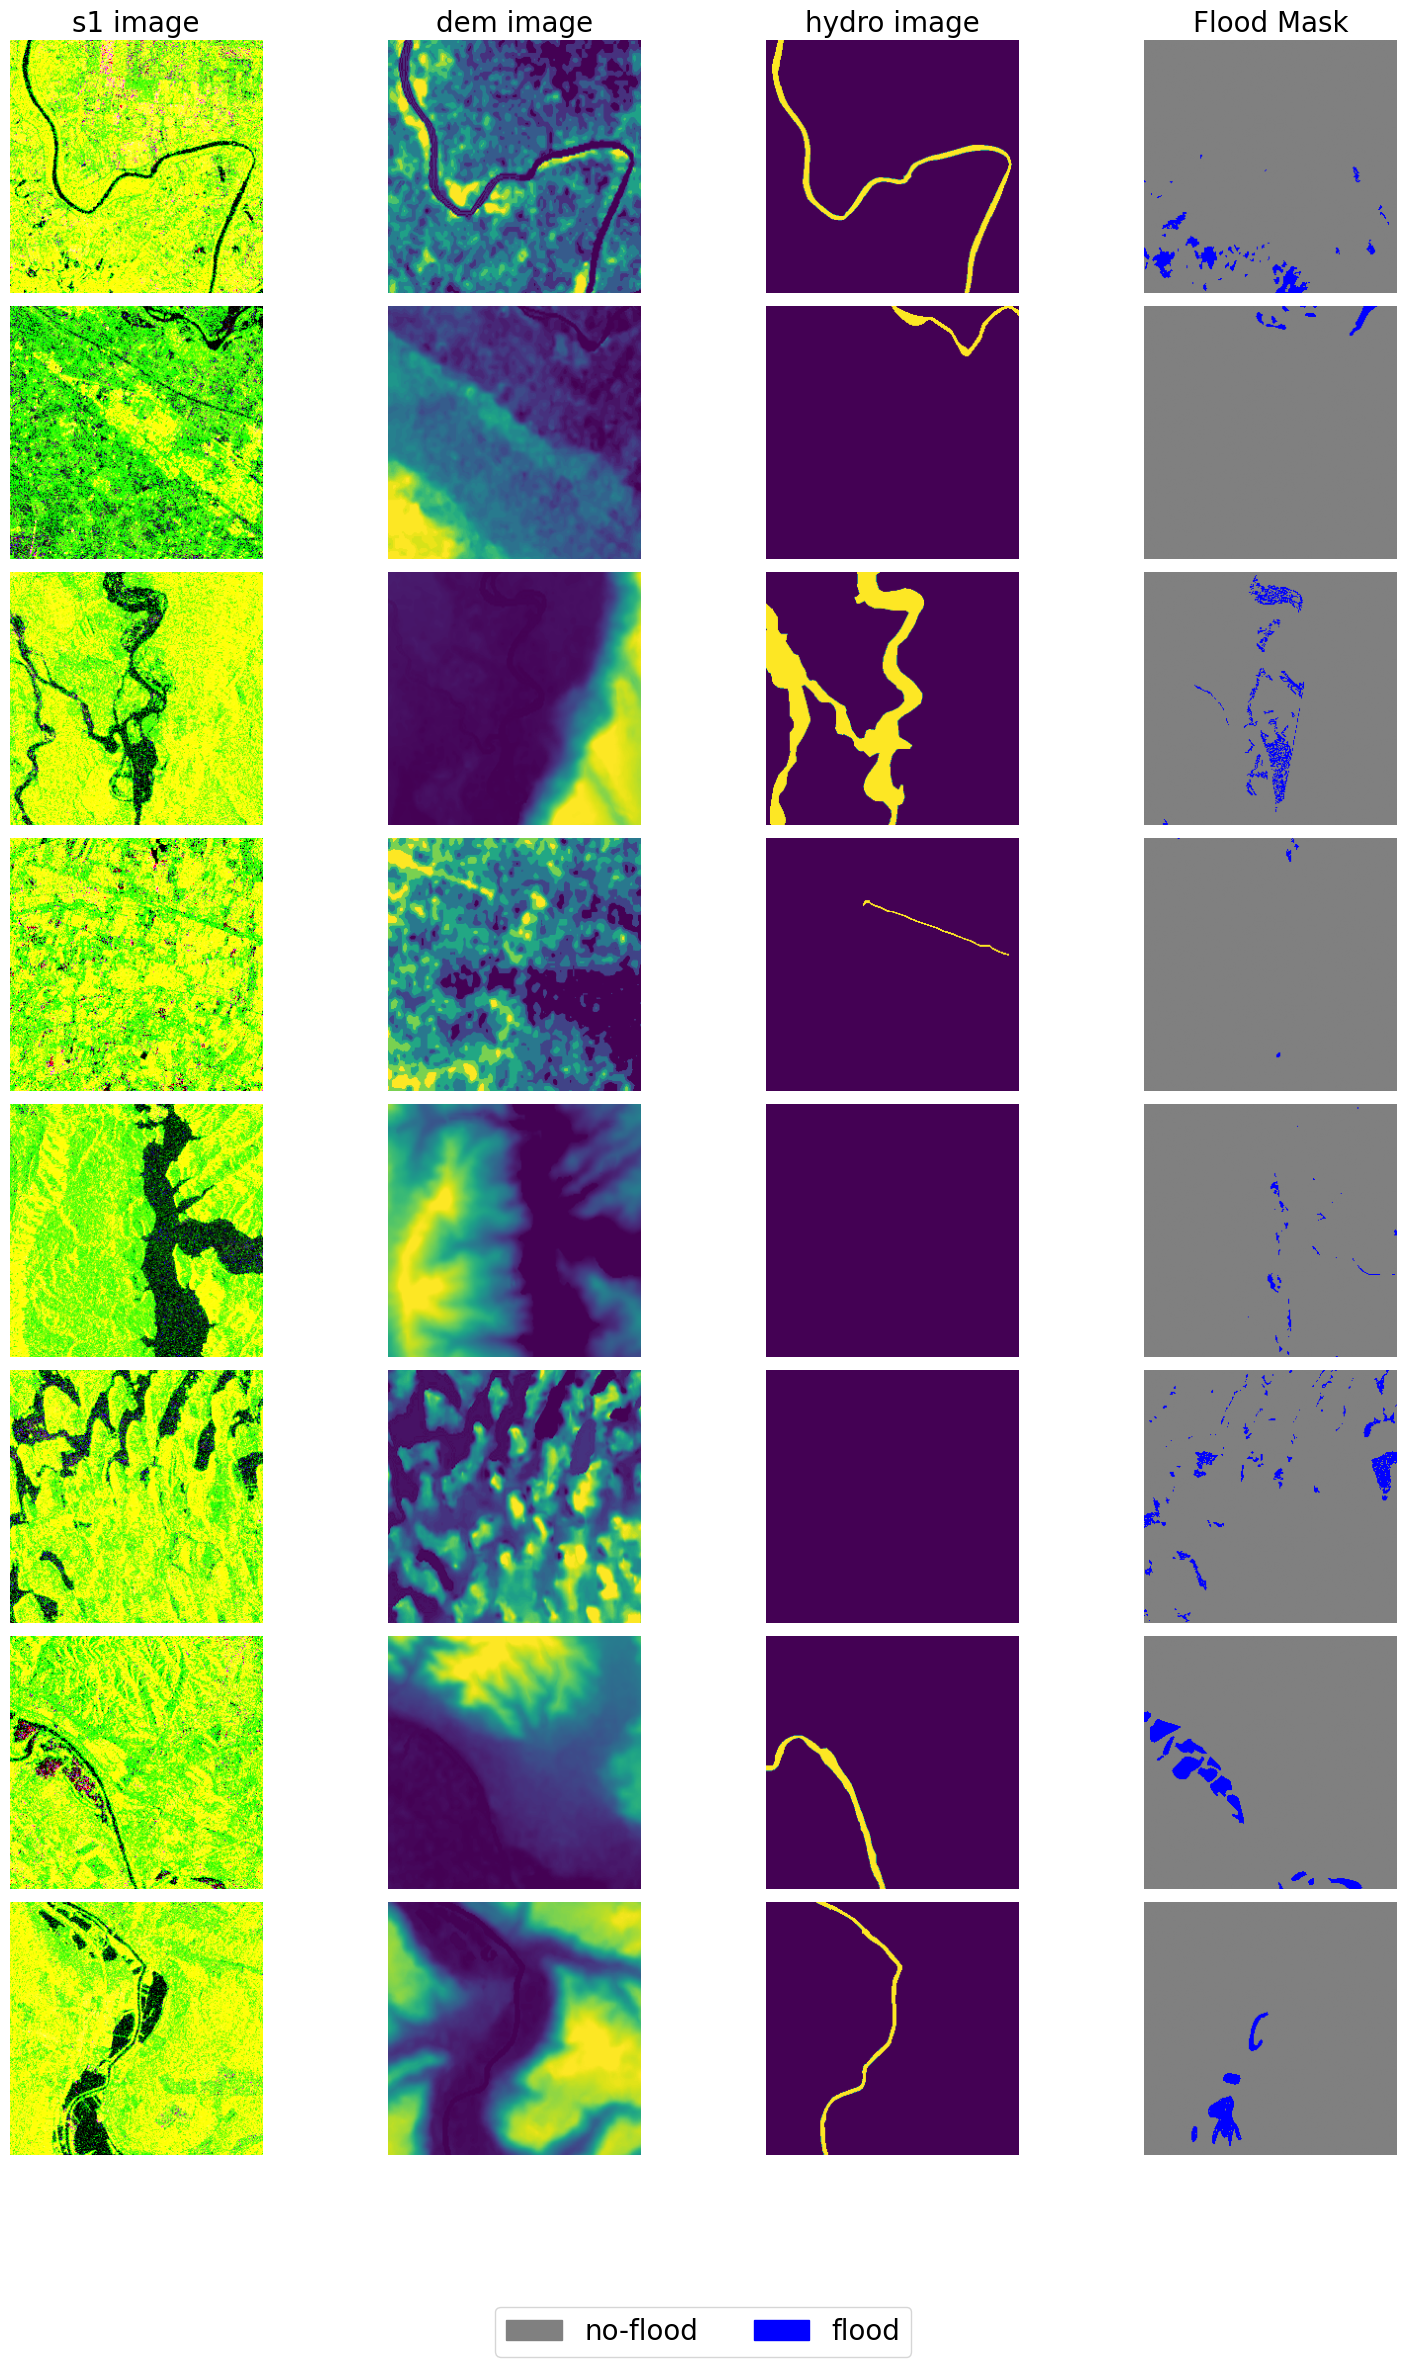

In [10]:
fig, batch = datamodule.visualize_batch()